<a href="https://colab.research.google.com/github/prajapatiraghulal/Anomaly_detection/blob/master/anomaly_detection_via_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib
!pip install mxnet-cu101==1.7.0.post0
!pip install sklearn
!pip install pandas
!pip install statsmodels
!pip install plotly

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import mxnet 
from mxnet.gluon import nn
from mxnet import gluon, image, npx,np
import matplotlib.pyplot as plt
import numpy
import cv2
from mxnet.gluon.model_zoo import vision
import os
import pandas as pd
import numpy
from mxnet.gluon import nn,rnn
from mxnet import init,autograd
npx.set_np()
import sklearn 


In [4]:
import json
from pathlib import Path
from IPython import display
%matplotlib inline
npx.set_np()

In [5]:
nab = Path.cwd()/r'drive/MyDrive/projects/anomaly_data'
data_path = nab/r'data'
labels_filepath = nab/r'labels/combined_labels.json'

In [6]:
training_filename =r'realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv'

valid_filename = r'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'

In [7]:
with open(labels_filepath,'r') as f:
    anomalies_timestamps = json.load(f)
    train_data_anomalies = anomalies_timestamps[training_filename]
    valid_data_anomalies = anomalies_timestamps[valid_filename]
    #print(train_data_anomalies, valid_data_anomalies)



In [8]:
train_pd = pd.read_csv(data_path/training_filename)
valid_pd = pd.read_csv(data_path/valid_filename)
print(train_pd.head(), valid_pd.head())

             timestamp  value
0  2014-02-14 14:30:00  6.456
1  2014-02-14 14:35:00  5.816
2  2014-02-14 14:40:00  6.268
3  2014-02-14 14:45:00  5.816
4  2014-02-14 14:50:00  5.862              timestamp   value
0  2014-04-10 00:02:00  14.012
1  2014-04-10 00:07:00  13.334
2  2014-04-10 00:12:00  15.000
3  2014-04-10 00:17:00  13.998
4  2014-04-10 00:22:00  14.332


In [9]:
def normalization(data):
    '''normalizes numpy data with sd=1, and mean=0'''
    mean = data.mean(keepdims=False)
    var = ((data-mean)**2).mean(keepdims=False)
    normalized_data = (data-mean)/np.sqrt(var)
    return normalized_data
    

In [10]:
#train and validation  data 
train_value = np.array(train_pd['value'], dtype=np.float32)
valid_value = np.array(valid_pd['value'], dtype=np.float32)

train_pd['normalize value'] =(normalization(train_value))
valid_pd['normalize value'] =(normalization(valid_value))




In [11]:
train_value.dtype

dtype('float32')

In [12]:
train_anomalies = train_pd[train_pd['timestamp'].isin(train_data_anomalies)]
valid_anomalies = valid_pd[valid_pd['timestamp'].isin(valid_data_anomalies)]

In [13]:
train_anomalies

,timestamp,value,normalize value
3080,2014-02-25 07:15:00,25.1033,4.652449
3579,2014-02-27 00:50:00,19.1650,3.0264418


In [14]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')


In [15]:
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [16]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

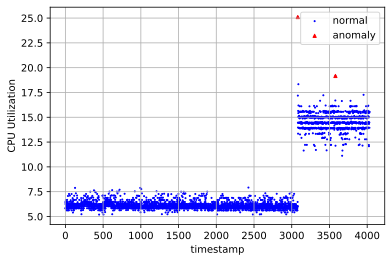

In [17]:
set_figsize((6,4))

axes = plt.gca()
axes.scatter(train_pd.iloc[:,0],train_pd.iloc[:,1],marker='.',s=5,c='blue' )
axes.scatter(train_anomalies.iloc[:,0],train_anomalies.iloc[:,1],marker='^',s=10,c='red')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly'])

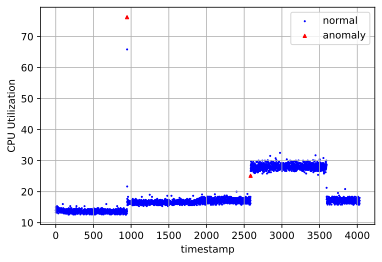

In [18]:
set_figsize((6,4))

axes = plt.gca()
axes.scatter(valid_pd.iloc[:,0],valid_pd.iloc[:,1],marker='.',s=5,c='blue' )
axes.scatter(valid_anomalies.iloc[:,0],valid_anomalies.iloc[:,1],marker='^',s=10,c='red')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly'])

In [19]:

from mxnet.gluon.data import Dataset,dataloader


In [20]:
#just creating 2nd reference name to train and valid value arrays
train_array = train_value
valid_array = valid_value

In [21]:
def load_array(data_arrays, batch_size):
    """Construct a Gluon data iterator."""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=False)

In [22]:
#to create iterable object of data with batch size of 64
batch_size =64

temp = list(train_pd['normalize value'])
temp.append(temp[-1])
train_value = np.array(temp)
train_iter= load_array((train_value[:-1],train_value[1:]),batch_size)

temp = list(valid_pd['normalize value'])
temp.append(temp[-1])
valid_value = np.array(temp)
valid_iter= load_array((valid_value[:-1],valid_value[1:]),batch_size)

In [23]:
#for i,(X,y) in enumerate(valid_iter):
#  print(i, X.shape, y.shape)
#  if(i==62):
#   print(X,y)

In [24]:


## creating RNN MODEL SPECIFIC LSTM

In [75]:
num_hiddens = 128
rnn_layer = rnn.RNN(num_hiddens)
rnn_layer.initialize()

In [76]:
state = rnn_layer.begin_state(batch_size=64)
len(state)

1

In [77]:
state[0].dtype

dtype('float32')

In [78]:
class RNN_model(nn.Block):
  def __init__(self, rnn_layer, length=1, **kwargs):
    super(RNN_model, self).__init__(**kwargs)
    self.rnn = rnn_layer
    self.length = length
    self.dense = nn.Dense(self.length)
    
    
  def forward(self, inputs, state):
    X = inputs
    Y, state= self.rnn(X,state)
    output = self.dense(Y.reshape(-1,128))
    return output, state
  
  def begin_state(self, *args, **kwargs):
    self.rnn.begin_state(*args,**kwargs)

In [79]:
net = RNN_model(rnn_layer)
net.initialize(force_reinit=True)

In [80]:
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'Adam',{'learning_rate':.021})
epochs = 16



In [ ]:
train_loss=[]
valid_loss=[]


In [82]:

for epoch in range(epochs):
  ll=0.0
  for i,(X,y) in enumerate(train_iter):
    with autograd.record():
      Y,state = net(X.reshape(1,64,-1),state)
      #print(Y,y)
      l= loss(Y.reshape(-1),y)
    l.backward()
    ll+=l.sum()
    #print(l.sum())
    #print(Y.shape)
    trainer.step(1)
  print(ll,end='\t')
  train_loss.append(ll)
  #print('***************************************')
  lll=0.0
  for i,(X,y) in enumerate(valid_iter):
    Y,state = net(X.reshape(1,64,-1),state)
    lo = loss(Y.reshape(y.shape),y)
    lll+=lo.sum()

  print(lll)
  valid_loss.append(lll)

    

128.78699	241.55032
115.30784	218.60378
194.15488	215.84048
242.08365	439.7716
167.68192	227.51512
108.92668	274.63394
88.519684	179.04488
83.1008	177.08554


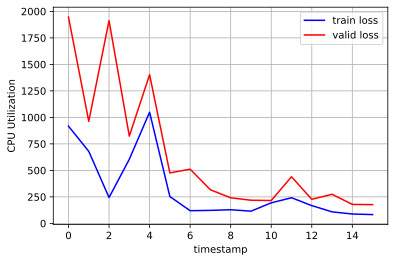

In [84]:
set_figsize((6,4))

axes = plt.gca()
axes.plot(range(16),train_loss,c='blue' )
axes.plot(range(16),valid_loss,c='red')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['train loss','valid loss'])

In [ ]:
## I can clearly see epoch no. 16 is best with both losses min compare to others 

In [85]:
lll=0.0
y_predict = []
x_predict=[]
for i,(X,y) in enumerate(valid_iter):
  Y,state = net(X.reshape(1,64,-1),state)
  lo = loss(Y.reshape(y.shape),y)
  y_predict.append(Y.reshape(-1))
  x_predict.append(X)
  lll+=lo.sum()
  
print(lll)

171.29019


In [86]:
len(x_predict), len(x_predict[0])

(63, 64)

In [87]:
len(y_predict), len(y_predict[0])

(63, 64)

In [88]:
xx= np.array(x_predict)
yy= np.array(y_predict)

In [89]:
loss = (xx-yy)**2

In [90]:
loss.sum()/(64*63)   #loss per value

array(0.02902839)

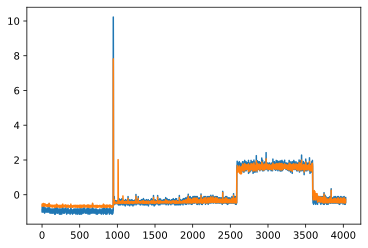

In [91]:
plt.plot(xx.asnumpy().reshape(-1))
plt.plot(yy.asnumpy().reshape(-1))


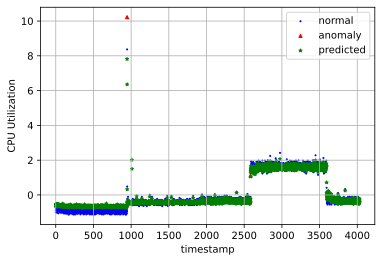

In [92]:
set_figsize((6,4))

axes = plt.gca()
axes.scatter(valid_pd.iloc[:,0],valid_pd.iloc[:,2],marker='.',s=5,c='blue' )
axes.scatter(valid_anomalies.iloc[:,0],valid_anomalies.iloc[:,2],marker='^',s=10,c='red')
axes.scatter(valid_pd.iloc[:,0], yy, marker='*',s=10, c='green')
set_axes(axes, xlabel='timestamp', ylabel='CPU Utilization', xlim=None, ylim=None, xscale='linear', yscale='linear', legend=['normal','anomaly','predicted'])